# Notebook 2: Tire Degradation Rules Implementation

This notebook focuses on implementing the rule set related to tire degradation for our F1 Strategy Engine. These rules are crucial for race strategy as they determine when a car should pit based on tire performance analysis.

## Overview of Degradation Rules

We'll implement three core rules:

1. **High Degradation Rate Pit Stop**
   - IF (DegradationRate > 0.15 AND TyreAge > 10)
   - THEN recommend priority pit stop
   - CONFIDENCE: 0.85

2. **Stint Extension for Low Degradation**
   - IF (DegradationRate < 0.08 AND TyreAge > 12 AND Position < 5)
   - THEN recommend extending current stint
   - CONFIDENCE: 0.75

3. **Early Degradation Warning**
   - IF (DegradationRate increases by more than 0.03 in 3 consecutive laps)
   - THEN recommend pit stop preparation
   - CONFIDENCE: 0.7

Each rule handles specific aspects of tire degradation strategy that F1 teams consider during races.

---

## 1. Importing necessary Libraries

In [113]:
# Import standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os
import sys


# Import Experta components
from experta import Rule, NOT, OR, AND, AS, MATCH, TEST, EXISTS
from experta import DefFacts, Fact, Field, KnowledgeEngine


####################### Import Custom Fact Classes ###################
from utils.N01_agent_setup import (
    TelemetryFact,
    DegradationFact,
    RaceStatusFact,
    StrategyRecommendation,
    F1StrategyEngine,
    transform_degradation_prediction
)
 
# Configuring plots 

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_context("notebook", font_scale= 1.2)

print("Libraries and fact classes loaded successfully.")

Libraries and fact classes loaded successfully.


---

## 2. Analyzing Degradation Data

In [114]:
# Load and prepare tire degradation data
def load_degradation_data(file_path='../../outputs/week5/tire_degradation_fuel_adjusted.csv'):
    """
    Load real tire degradation data and prepare it for rule evaluation
    
    Args:
        file_path: Path to the degradation data CSV file
        
    Returns:
        DataFrame with processed tire degradation data
    """
    df = pd.read_csv(file_path)
    print(f"Successfully loaded data from {file_path}")
    
    # Convert float columns to integers where appropriate
    integer_columns = ['Position', 'TyreAge', 'DriverNumber', 'CompoundID', 'TeamID']
    for col in integer_columns:
        if col in df.columns:
            df[col] = df[col].astype(int)
    
    # Sort data for consistency
    df = df.sort_values(['DriverNumber', 'Stint', 'TyreAge'])
    
    # Calculate race lap by accumulating TyreAge across stints
    # First, get the maximum TyreAge for each completed stint
    max_age_by_stint = df.groupby(['DriverNumber', 'Stint'])['TyreAge'].max().reset_index()
    max_age_by_stint = max_age_by_stint.rename(columns={'TyreAge': 'StintLength'})
    
    # Create a lookup for previous stint lengths
    stint_lengths = {}
    for driver in df['DriverNumber'].unique():
        driver_stints = max_age_by_stint[max_age_by_stint['DriverNumber'] == driver]
        
        # Calculate cumulative stint lengths
        cumulative_lengths = [0]  # Start with 0 for the first stint
        for i in range(len(driver_stints) - 1):
            cumulative_lengths.append(
                cumulative_lengths[-1] + driver_stints.iloc[i]['StintLength']
            )
        
        # Store in dictionary
        stint_lengths[driver] = {
            stint: length for stint, length in zip(
                driver_stints['Stint'], cumulative_lengths
            )
        }
    
    # Function to calculate race lap
    def calculate_race_lap(row):
        driver = row['DriverNumber']
        stint = row['Stint']
        tyre_age = row['TyreAge']
        
        # Get the starting lap for this stint
        start_lap = stint_lengths.get(driver, {}).get(stint, 0)
        
        # Add current TyreAge to get race lap
        return start_lap + tyre_age
    
    # Apply function to calculate race lap
    df['RaceLap'] = df.apply(calculate_race_lap, axis=1)
    
    # For each driver-stint combination, calculate previous degradation rates
    # This will be useful for Rule 3 (Early Degradation Warning)
    def get_previous_rates(group, n=3):
        """Get previous n degradation rates for each row in the group"""
        rates = []
        for i in range(len(group)):
            if i < n:
                # Not enough previous data
                rates.append(group.iloc[:i+1]['DegradationRate'].tolist())
            else:
                # Get last n rates including current
                rates.append(group.iloc[i-n+1:i+1]['DegradationRate'].tolist())
        return rates
    
    # Apply function to each driver-stint group
    df['PreviousRates'] = df.groupby(['DriverNumber', 'Stint']).apply(
        lambda x: get_previous_rates(x)
    ).explode().tolist()
    
    return df



In [115]:
# Load the data
degradation_data = load_degradation_data()

# Display sample of the data
print("Loaded degradation data:")
display(degradation_data.head())



Successfully loaded data from ../../outputs/week5/tire_degradation_fuel_adjusted.csv
Loaded degradation data:


C:\Users\victo\AppData\Local\Temp\ipykernel_28728\4014458323.py:78: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['PreviousRates'] = df.groupby(['DriverNumber', 'Stint']).apply(


,Stint,SpeedI1,SpeedI2,SpeedFL,SpeedST,Position,LapsSincePitStop,DRSUsed,TeamID,CompoundID,TyreAge,FuelLoad,DriverNumber,FuelAdjustedLapTime,FuelAdjustedDegPercent,DegradationRate,RaceLap,PreviousRates
0,1.0,256.0,261.0,276.0,275.0,1,1.0,0,9,2,1,0.9848,1,83.935,0.000000,0.000000,1.0,[0.0]
16,1.0,252.0,257.0,276.0,295.0,1,2.0,0,9,2,2,0.9697,1,80.457,-4.143683,-3.941625,2.0,"[0.0, -3.941624999999988]"
20,1.0,249.0,256.0,276.0,297.0,1,3.0,0,9,2,3,0.9545,1,80.609,-3.962590,0.232092,3.0,"[0.0, -3.941624999999988, 0.2320916666666619]"
48,1.0,255.0,256.0,276.0,300.0,1,4.0,0,9,2,4,0.9394,1,80.511,-4.079347,0.073592,4.0,"[-3.941624999999988, 0.2320916666666619, 0.073..."
50,1.0,254.0,256.0,277.0,301.0,1,5.0,0,9,2,5,0.9242,1,80.503,-4.088878,0.007353,5.0,"[0.2320916666666619, 0.0735921568627446, 0.007..."


---

### Chossoing thresholds for degradation

DegradationRate statistics:


count    1180.000000
mean        0.000665
std         0.591501
min        -3.941625
25%        -0.050319
50%         0.065385
75%         0.167878
max         2.113000
Name: DegradationRate, dtype: float64


Statistics for positive degradation values only:


count    688.000000
mean       0.248009
std        0.296526
min        0.007353
25%        0.111207
50%        0.148136
75%        0.280840
max        2.113000
Name: DegradationRate, dtype: float64

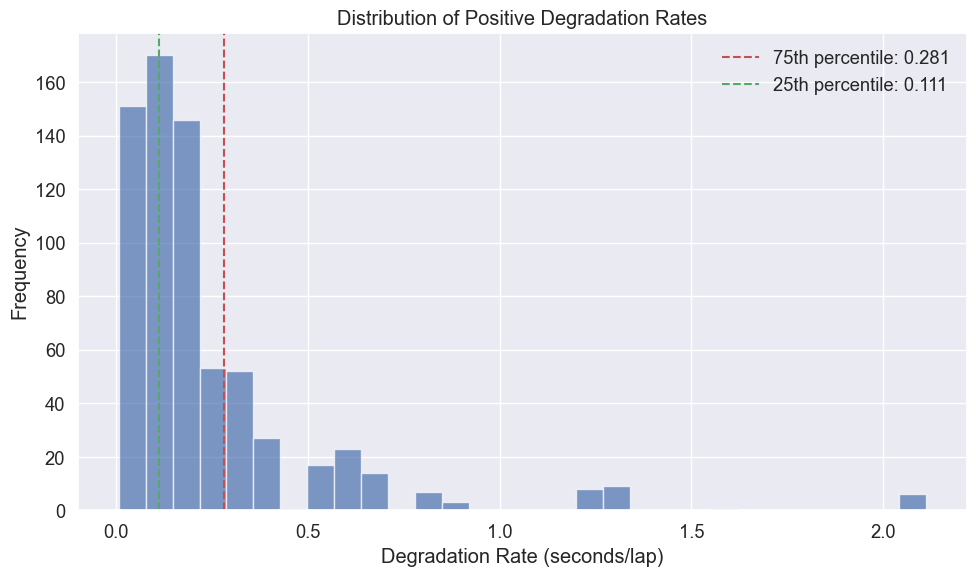


Suggested thresholds based on data distribution:
High Degradation Threshold: 0.281 seconds/lap
Low Degradation Threshold: 0.111 seconds/lap


In [116]:
# Analyze DegradationRate distribution to set appropriate thresholds
print("DegradationRate statistics:")
display(degradation_data['DegradationRate'].describe())

# Distribution of positive degradation values (actual degradation)
positive_deg = degradation_data[degradation_data['DegradationRate'] > 0]['DegradationRate']
print("\nStatistics for positive degradation values only:")
display(positive_deg.describe())

# Visualize the distribution
plt.figure(figsize=(10, 6))
plt.hist(positive_deg, bins=30, alpha=0.7)
plt.axvline(positive_deg.quantile(0.75), color='r', linestyle='--', 
           label=f'75th percentile: {positive_deg.quantile(0.75):.3f}')
plt.axvline(positive_deg.quantile(0.25), color='g', linestyle='--',
           label=f'25th percentile: {positive_deg.quantile(0.25):.3f}')
plt.xlabel('Degradation Rate (seconds/lap)')
plt.ylabel('Frequency')
plt.title('Distribution of Positive Degradation Rates')
plt.legend()
plt.tight_layout()
plt.show()

# Suggested thresholds based on data percentiles
high_degradation_threshold = positive_deg.quantile(0.75)  # 75th percentile
low_degradation_threshold = positive_deg.quantile(0.25)   # 25th percentile

print(f"\nSuggested thresholds based on data distribution:")
print(f"High Degradation Threshold: {high_degradation_threshold:.3f} seconds/lap")
print(f"Low Degradation Threshold: {low_degradation_threshold:.3f} seconds/lap")

---

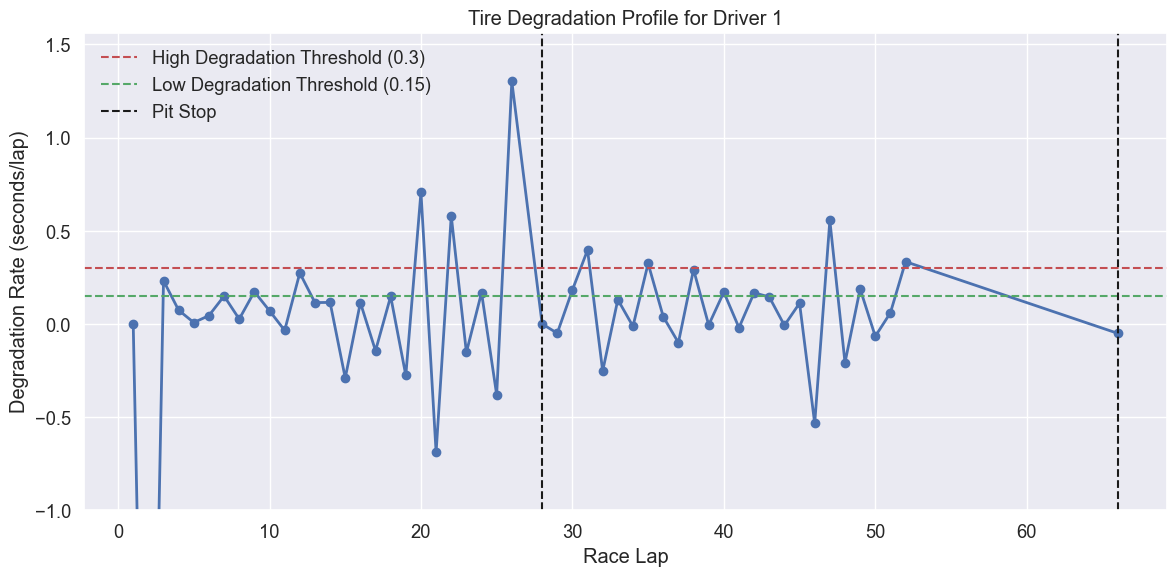

In [117]:
# Plot degradation for a sample driver across race laps
sample_driver = degradation_data['DriverNumber'].unique()[0]
driver_data = degradation_data[degradation_data['DriverNumber'] == sample_driver]

# Visualize degradation with the correct thresholds and limited y-axis
plt.figure(figsize=(12, 6))
plt.plot(driver_data['RaceLap'], driver_data['DegradationRate'], 'o-', linewidth=2)
plt.axhline(y=0.3, color='r', linestyle='--', label='High Degradation Threshold (0.3)')
plt.axhline(y=0.15, color='g', linestyle='--', label='Low Degradation Threshold (0.15)')

# Mark stint changes
stint_changes = []
for i in range(1, len(driver_data)):
    if driver_data.iloc[i]['Stint'] != driver_data.iloc[i-1]['Stint']:
        stint_changes.append(driver_data.iloc[i]['RaceLap'])

for lap in stint_changes:
    plt.axvline(x=lap, color='k', linestyle='--', label='Pit Stop' if 'Pit Stop' not in plt.gca().get_legend_handles_labels()[1] else "")

# Establecer límites del eje Y - esto cortará valores por debajo de -1
plt.ylim(bottom=-1)

plt.xlabel('Race Lap')
plt.ylabel('Degradation Rate (seconds/lap)')
plt.title(f'Tire Degradation Profile for Driver {sample_driver}')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

---

## 3. Defining the Engine Class with all three degradation rules

In [118]:
# Update the DegradationFact class to include predicted_rates
from experta import Fact, Field, KnowledgeEngine, Rule, NOT, OR, AND, AS, MATCH, TEST, EXISTS

class DegradationFact(Fact):
    """
    Facts about tire degradation including predictions
    """
    degradation_rate = Field(float, mandatory=False)           # Seconds lost per lap due to degradation
    previous_rates = Field(list, mandatory=False)              # Last N degradation rates for trend analysis
    fuel_adjusted_deg_percent = Field(float, mandatory=False)  # Percentage degradation adjusted for fuel
    predicted_rates = Field(list, mandatory=False)             # Predicted future degradation rates

# Define the F1DegradationRules engine class that inherits from F1StrategyEngine
class F1DegradationRules(F1StrategyEngine):
    """
    Engine implementing tire degradation related rules for F1 strategy.
    Inherits the base functionality from F1StrategyEngine.
    """
    
    @Rule(
        DegradationFact(degradation_rate=TEST(lambda x: x > 0.15)),
        TelemetryFact(tire_age=TEST(lambda x: x > 10)),
        RaceStatusFact(lap=MATCH.lap)
    )
    def high_degradation_pit_stop(self, lap):
        """
        Rule 1: High Degradation Rate Pit Stop
        IF (DegradationRate > 0.15 AND TyreAge > 10)
        THEN recommend priority pit stop
        CONFIDENCE: 0.85
        """
        self.declare(
            StrategyRecommendation(
                action="pit_stop",
                confidence=0.85,
                explanation="High tire degradation rate detected above critical threshold with significant tire age",
                priority=2,  # Higher priority due to performance implications
                lap_issued=lap
            )
        )
        self.record_rule_fired("high_degradation_pit_stop")
    
    @Rule(
        DegradationFact(degradation_rate=TEST(lambda x: x < 0.08)),
        TelemetryFact(tire_age=TEST(lambda x: x > 12)),
        TelemetryFact(position=TEST(lambda x: x < 5)),
        RaceStatusFact(lap=MATCH.lap)
    )
    def stint_extension_recommendation(self, lap):
        """
        Rule 2: Stint Extension for Low Degradation
        IF (DegradationRate < 0.08 AND TyreAge > 12 AND Position < 5)
        THEN recommend extending current stint
        CONFIDENCE: 0.75
        """
        self.declare(
            StrategyRecommendation(
                action="extend_stint",
                confidence=0.75,
                explanation="Low tire degradation despite tire age. Recommend extending the current stint to maximize strategic advantage.",
                priority=1,
                lap_issued=lap
            )
        )
        self.record_rule_fired("stint_extension_recommendation")
    
    @Rule(
        DegradationFact(previous_rates=MATCH.rates),
        TEST(lambda rates: rates is not None and isinstance(rates, list) and 
             len(rates) >= 3 and (rates[-1] - rates[-3]) > 0.03),
        RaceStatusFact(lap=MATCH.lap)
    )
    def early_degradation_warning(self, rates, lap):
        """
        Rule 3: Early Degradation Warning
        IF (DegradationRate increases by more than 0.03 in 3 consecutive laps)
        THEN recommend pit stop preparation
        CONFIDENCE: 0.7
        """
        self.declare(
            StrategyRecommendation(
                action="prepare_pit",
                confidence=0.7,
                explanation=f"Degradation rate increasing rapidly over the last 3 laps (trend: {rates[-3]:.3f} → {rates[-1]:.3f}). Prepare for potential pit stop.",
                priority=1,
                lap_issued=lap
            )
        )
        self.record_rule_fired("early_degradation_warning")
        
    # Rule based on model predictions
    @Rule(
        DegradationFact(predicted_rates=MATCH.pred_rates),
        TEST(lambda pred_rates: pred_rates is not None and isinstance(pred_rates, list) and 
             len(pred_rates) > 0 and pred_rates[0] > 0.2),
        TelemetryFact(tire_age=TEST(lambda x: x > 8)),
        RaceStatusFact(lap=MATCH.lap)
    )
    def predicted_high_degradation_alert(self, pred_rates, lap):
        """
        Rule 4: Predicted High Degradation Alert
        IF (Predicted future degradation rate > 0.2 AND TyreAge > 8)
        THEN recommend considering pit stop based on model prediction
        CONFIDENCE: 0.8
        """
        self.declare(
            StrategyRecommendation(
                action="consider_pit",
                confidence=0.8,
                explanation=f"Model predicts critical degradation in upcoming laps (predicted rate: {pred_rates[0]:.3f}s/lap). Consider pit stop strategy.",
                priority=2,
                lap_issued=lap
            )
        )
        self.record_rule_fired("predicted_high_degradation_alert")

---

In [119]:
import sys
import os
project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
if project_root not in sys.path:
    sys.path.append(project_root)
from ML_tyre_pred.ML_utils.N01_tire_prediction import EnhancedTCN

## 4. Loading prediction models

In [120]:
def load_prediction_models(models_dir="../../outputs/week5/models/"):
    """
    Loads the tire degradation prediction models (general model and compound-specific models).
    
    This function initializes and loads the previously trained TCN models for tire degradation
    prediction from saved PyTorch state dictionaries (.pth files).
    
    Args:
        models_dir (str): Path to the directory containing model files. 
                          Defaults to "../../outputs/week5/models/".
    
    Returns:
        dict: Dictionary with loaded models where keys are model names and values are 
              the initialized PyTorch models with loaded weights.
    """
    import os
    import pickle
    import torch
    
    # Define input and output dimensions used during training
    # These must match the original architecture
    input_size = 16  # Number of input features (columns in the sequence data)
    output_size = 3  # Number of future laps to predict degradation for
    
    # Dictionary to store all loaded models
    models = {}
    
    # Dictionary mapping model names to their respective filenames
    model_files = {
        'general': 'tire_degradation_tcn.pth',  # Main model trained on all compounds
        'soft': 'tcn_compound_1.pth',           # Model specialized for soft tires (compound_id=1)
        'medium': 'tcn_compound_2.pth',         # Model specialized for medium tires (compound_id=2)
        'hard': 'tcn_compound_3.pth'            # Model specialized for hard tires (compound_id=3)
    }
    
    # Iterate through each model to load
    for model_name, file_name in model_files.items():
        try:
            # Construct the full path to the model file
            model_path = os.path.join(models_dir, file_name)
            
            # Handle PyTorch models (.pth files)
            if file_name.endswith('.pth'):
                # Initialize the model architecture with the correct parameters
                # This creates the network structure but with random weights
                model = EnhancedTCN(input_size=input_size, output_size=output_size)
                
                # Load the saved weights (state dictionary) into the model
                # map_location ensures the model loads correctly even if saved on GPU
                state_dict = torch.load(model_path, map_location=torch.device('cpu'))
                model.load_state_dict(state_dict)
                
                # Set the model to evaluation mode (disables dropout, etc.)
                model.eval()
                
                # Store the loaded model in our dictionary
                models[model_name] = model
                
            # Handle pickle files (for any non-PyTorch models)
            else:
                with open(model_path, 'rb') as f:
                    models[model_name] = pickle.load(f)
            
            # Log successful model loading
            print(f"Model '{model_name}' successfully loaded from {file_name}")
            
        except Exception as e:
            # Log any errors that occur during model loading
            print(f"Error loading model '{model_name}': {e}")
    
    return models
degradation_models = load_prediction_models()


Model 'general' successfully loaded from tire_degradation_tcn.pth
Model 'soft' successfully loaded from tcn_compound_1.pth
Model 'medium' successfully loaded from tcn_compound_2.pth
Model 'hard' successfully loaded from tcn_compound_3.pth


C:\Users\victo\AppData\Local\Temp\ipykernel_28728\2229092996.py:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location=torch.devi

---

In [121]:
# Define compound names and colors for visualization
compound_names = {
    1: 'SOFT',
    2: 'MEDIUM',
    3: 'HARD',
    4: 'INTERMEDIATE',
    5: 'WET'
}

compound_colors = {
    1: 'red',     # SOFT
    2: 'yellow',  # MEDIUM
    3: 'gray',    # HARD
    4: 'green',   # INTERMEDIATE
    5: 'blue'     # WET
}

# Function to determine race phase based on lap progress
def calculate_race_phase(current_lap, total_laps):
    """Calculate the current phase of the race."""
    percentage = (current_lap / total_laps) * 100
    if percentage < 25:
        return "start"
    elif percentage > 75:
        return "end"
    else:
        return "mid"

# Import necessary functions from N01_tire_prediction module
# We'll use sys.path to ensure we can import from the module location
import sys
import os
import importlib

# Add the directory containing N01_tire_prediction to the path
module_dir = "../../src/ml"  # Adjust this path as needed
if module_dir not in sys.path:
    sys.path.append(module_dir)

# Try to import functions from the module

from ML_tyre_pred.ML_utils.N01_tire_prediction import (
        EnhancedTCN,
        process_raw_lap_data,
        ensemble_predict,
        predict_tire_degradation_live,
     predict_with_ensemble
)
import torch
    
    


In [122]:
# Function to create DegradationFact from model output and predictions
def create_degradation_fact(degradation_rate, previous_rates=None, predicted_rates=None):
    """
    Creates a DegradationFact safely handling previous_rates to prevent NaN errors
    and including model predictions
    
    Args:
        degradation_rate: Current degradation rate value
        previous_rates: List of previous degradation rates or None
        predicted_rates: List of predicted future degradation rates or None
        
    Returns:
        A valid DegradationFact instance
    """
    # If previous_rates is None, NaN, or not a list, initialize it as an empty list
    if previous_rates is None or (isinstance(previous_rates, float) and np.isnan(previous_rates)) or not isinstance(previous_rates, list):
        previous_rates = []
    
    # Ensure all values in the list are valid (not NaN)
    if previous_rates:
        previous_rates = [float(rate) for rate in previous_rates if not (isinstance(rate, float) and np.isnan(rate))]
    
    # If predicted_rates is None or not a list, initialize it as an empty list
    if predicted_rates is None or not isinstance(predicted_rates, list):
        predicted_rates = []
    
    # Ensure all values in predicted_rates are valid (not NaN)
    if predicted_rates:
        predicted_rates = [float(rate) for rate in predicted_rates if not (isinstance(rate, float) and np.isnan(rate))]
    
    # Create DegradationFact with the original and processed data
    return DegradationFact(
        degradation_rate=float(degradation_rate),
        previous_rates=previous_rates,
        predicted_rates=predicted_rates
    )






# Función corregida para analizar datos del piloto y hacer predicciones
def analyze_driver_data(df, driver_number, models):
    """
    Analiza los datos de un piloto específico y genera predicciones
    
    Args:
        df: DataFrame con datos de degradación procesados
        driver_number: Número del piloto a analizar
        models: Diccionario de modelos cargados
        
    Returns:
        dict: Resultados del análisis incluyendo valores actuales y predicciones
    """
    # Asegurar que driver_number es un entero de Python
    driver_number = int(driver_number)
    
    # Filtrar datos del piloto especificado
    driver_data = df[df['DriverNumber'] == driver_number]
    
    if len(driver_data) == 0:
        print(f"No se encontraron datos para el piloto {driver_number}")
        return None
    
    # Ordenar datos por vuelta
    driver_data = driver_data.sort_values('RaceLap')
    
    # Obtener los datos de la última vuelta
    last_lap_data = driver_data.iloc[-1]
    
    # Crear lista de tasas previas (hasta 3 vueltas anteriores si están disponibles)
    previous_rates = []
    if len(driver_data) >= 3:
        # Obtener las últimas 3 filas
        last_three = driver_data.tail(3)
        previous_rates = last_three['DegradationRate'].tolist()
    
    # Obtener información del compuesto para la selección del modelo
    compound_id = int(last_lap_data['CompoundID'])
    compound_name = compound_names.get(compound_id, f"Compound {compound_id}")
    
    # Generar predicciones
    predicted_rates = []
    
    try:
        # Preparar entrada para predicción
        import torch
        # Obtener las últimas 5 vueltas o menos si no están disponibles
        window_size = min(5, len(driver_data))
        window = driver_data.tail(window_size)
        
        # Definir características utilizadas por el modelo
        feature_cols = ['TyreAge', 'CompoundID', 'Position', 'DegradationRate']
        if 'FuelAdjustedLapTime' in window.columns:
            feature_cols.append('FuelAdjustedLapTime')
        if 'FuelAdjustedDegPercent' in window.columns:
            feature_cols.append('FuelAdjustedDegPercent')
        
        # Filtrar solo columnas que realmente existen
        actual_cols = [col for col in feature_cols if col in window.columns]
        
        # Obtener la matriz de características
        X = window[actual_cols].values
        
        # Si no tenemos 5 vueltas, rellenar con repeticiones de la primera fila
        if len(X) < 5:
            pad_size = 5 - len(X)
            X = np.vstack([np.tile(X[0], (pad_size, 1)), X])
        
        # Convertir al formato tensor esperado por el modelo
        X_tensor = torch.FloatTensor(X).unsqueeze(0)  # Añadir dimensión de lote
        
        # Usar ensemble_predict directamente en lugar de predict_with_ensemble
        if 'ensemble_predict' in globals() and 'general' in models:
            predictions, _ = ensemble_predict(
                X=X_tensor, 
                compound_id=compound_id,
                global_model=models['general'],  # Modelo global
                specialized_models=models,       # Diccionario con todos los modelos
                device='cpu'                     # Usar CPU para inferencia
            )
            predicted_rates = predictions[0] if len(predictions.shape) > 1 else predictions
            
        else:
            # Estimación simple basada en el compuesto y edad del neumático
            base_rate = last_lap_data['DegradationRate']
            multiplier = 1.15  # Factor base
            if compound_id == 1:  # Soft
                multiplier = 1.3
            elif compound_id == 2:  # Medium
                multiplier = 1.15
            else:  # Hard
                multiplier = 1.07
                
            # Progresión simple para las siguientes 3 vueltas
            predicted_rates = [
                base_rate * multiplier,
                base_rate * multiplier * multiplier,
                base_rate * multiplier * multiplier * multiplier
            ]
            
        print(f"Predicciones generadas: {predicted_rates}")
        
    except Exception as e:
        print(f"Error al generar predicciones: {e}")
        # Fallback a estimaciones simples
        base_rate = float(last_lap_data['DegradationRate'])
        predicted_rates = [base_rate * 1.1, base_rate * 1.2, base_rate * 1.3]  # Valores crecientes simples
    
    # Devolver resultados del análisis
    return {
        'driver_number': driver_number,
        'compound_id': compound_id,
        'compound_name': compound_name,
        'tire_age': int(last_lap_data['TyreAge']),
        'position': int(last_lap_data['Position']),
        'current_degradation': float(last_lap_data['DegradationRate']),
        'previous_rates': previous_rates,
        'predicted_rates': predicted_rates
    }























# Función para aplicar reglas a datos reales usando la función predict_tire_degradation_live
def apply_degradation_rules_with_predictions(df, driver_number):
    """
    Aplica las reglas de degradación a datos reales para un piloto específico,
    utilizando la función existente predict_tire_degradation_live
    
    Args:
        df: DataFrame con datos de degradación procesados
        driver_number: Número del piloto a analizar
        
    Returns:
        Lista de recomendaciones generadas
    """
    # Filtrar datos para el piloto especificado
    driver_data = df[df['DriverNumber'] == driver_number]
    
    if len(driver_data) == 0:
        print(f"No se encontraron datos para el piloto {driver_number}")
        return []
    
    # Usar directamente predict_tire_degradation_live para obtener predicciones
    try:
        predictions_df = predict_tire_degradation_live(df)
        driver_predictions = predictions_df[predictions_df['CompoundID'] == driver_data['CompoundID'].iloc[0]]
        
        # Obtener los datos más recientes
        latest_prediction = driver_predictions.iloc[-1] if len(driver_predictions) > 0 else None
        
        if latest_prediction is None:
            print(f"No se pudieron generar predicciones para el piloto {driver_number}")
            predicted_rates = []
        else:
            # Extraer tasas de degradación predichas
            predicted_rates = [
                latest_prediction.get('PredictedDegRate_Lap1', 0),
                latest_prediction.get('PredictedDegRate_Lap2', 0),
                latest_prediction.get('PredictedDegRate_Lap3', 0)
            ]
    except Exception as e:
        print(f"Error al usar predict_tire_degradation_live: {e}")
        # Fallback simple
        predicted_rates = []
    
    # Obtener datos para el análisis
    latest_data = driver_data.iloc[-1]
    
    # Obtener tasas previas (hasta 3 vueltas anteriores)
    previous_rates = []
    if len(driver_data) >= 3:
        last_three = driver_data.tail(3)
        previous_rates = last_three['DegradationRate'].tolist()
    
    # Crear instancia del motor
    engine = F1DegradationRules()
    engine.reset()
    
    # Crear hechos con predicciones
    deg_fact = create_degradation_fact(
        degradation_rate=float(latest_data['DegradationRate']),
        previous_rates=previous_rates,
        predicted_rates=predicted_rates
    )
    
    # Crear hecho de telemetría
    tel_fact = TelemetryFact(
        tire_age=int(latest_data['TyreAge']),
        position=int(latest_data['Position']),
        compound_id=int(latest_data['CompoundID']),
        driver_number=int(driver_number)
    )
    
    # Establecer estado de carrera (asumiendo que estamos en la vuelta 20 de 70)
    race_lap = int(latest_data['RaceLap']) if 'RaceLap' in latest_data else 20
    race_status = RaceStatusFact(
        lap=race_lap,
        total_laps=70,  # Longitud estándar de carrera
        race_phase=calculate_race_phase(race_lap, 70)
    )
    
    # Mostrar información de depuración
    compound_name = compound_names.get(int(latest_data['CompoundID']), "Unknown")
    print(f"\nAnálisis para Piloto {driver_number} ({compound_name}):")
    print(f"Degradación Actual: {latest_data['DegradationRate']:.3f} s/lap")
    print(f"Edad del Neumático: {latest_data['TyreAge']} vueltas")
    print(f"Posición: {latest_data['Position']}")
    print(f"Tasas previas: {previous_rates}")
    print(f"Tasas predichas: {predicted_rates}")
    
    # Declarar hechos
    engine.declare(deg_fact)
    engine.declare(tel_fact)
    engine.declare(race_status)
    
    # Ejecutar el motor
    engine.run()
    
    # Devolver recomendaciones
    return engine.get_recommendations()

In [123]:
# Fix data types in the DataFrame
print("Converting DataFrame column types...")
# List columns that should be integers
int_columns = ['DriverNumber', 'Position', 'CompoundID', 'TyreAge', 'Stint']
# List columns that should be floats
float_columns = ['DegradationRate', 'FuelAdjustedDegPercent']

# Convert columns to appropriate types
for col in int_columns:
    if col in degradation_data.columns:
        degradation_data[col] = degradation_data[col].astype(int)
        print(f"Converted {col} to int")

for col in float_columns:
    if col in degradation_data.columns:
        degradation_data[col] = degradation_data[col].astype(float)
        print(f"Converted {col} to float")

# Ensure RaceLap is an integer if it exists
if 'RaceLap' in degradation_data.columns:
    degradation_data['RaceLap'] = degradation_data['RaceLap'].astype(int)
    print("Converted RaceLap to int")

print("DataFrame data types fixed.")

# Check available columns
print("\nAvailable columns in the dataset:")
print(degradation_data.columns.tolist())

# Inspect data for a sample driver
sample_driver = degradation_data['DriverNumber'].unique()[0]
driver_data = degradation_data[degradation_data['DriverNumber'] == sample_driver].sort_values('RaceLap')

# Display sample data with only columns that exist
available_columns = ['RaceLap', 'TyreAge', 'CompoundID', 'Position', 'DegradationRate']
existing_columns = [col for col in available_columns if col in driver_data.columns]

print(f"\nSample data for Driver {sample_driver}:")
print(driver_data[existing_columns].head())

Converting DataFrame column types...
Converted DriverNumber to int
Converted Position to int
Converted CompoundID to int
Converted TyreAge to int
Converted Stint to int
Converted DegradationRate to float
Converted FuelAdjustedDegPercent to float
Converted RaceLap to int
DataFrame data types fixed.

Available columns in the dataset:
['Stint', 'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST', 'Position', 'LapsSincePitStop', 'DRSUsed', 'TeamID', 'CompoundID', 'TyreAge', 'FuelLoad', 'DriverNumber', 'FuelAdjustedLapTime', 'FuelAdjustedDegPercent', 'DegradationRate', 'RaceLap', 'PreviousRates']

Sample data for Driver 1:
    RaceLap  TyreAge  CompoundID  Position  DegradationRate
0         1        1           2         1         0.000000
16        2        2           2         1        -3.941625
20        3        3           2         1         0.232092
48        4        4           2         1         0.073592
50        5        5           2         1         0.007353


In [ ]:
# Apply rules with model predictions
recommendations = apply_degradation_rules_with_predictions(degradation_data, driver_number)

# Display recommendations
if recommendations:
    print(f"\nStrategy recommendations for Driver {sample_driver}:")
    for i, rec in enumerate(recommendations, 1):
        print(f"\n{i}. Action: {rec['action'].upper()}")
        print(f"   Confidence: {rec['confidence']:.2f}")
        print(f"   Explanation: {rec['explanation']}")
        print(f"   Priority: {rec['priority']}")
        print(f"   Lap Issued: {rec['lap_issued']}")
else:
    print(f"No recommendations generated for Driver {sample_driver}")

# Visualize recommendations in the context of degradation data
def plot_degradation_with_predictions(df, driver_number, recommendations, models):
    """
    Plot degradation data with recommendations highlighted and predictions shown
    
    Args:
        df: DataFrame with degradation data
        driver_number: Driver number to plot
        recommendations: List of recommendations from the engine
        models: Dictionary of loaded models
    """
    driver_data = df[df['DriverNumber'] == driver_number].sort_values('RaceLap')
    
    if len(driver_data) == 0:
        print(f"No data found for driver {driver_number}")
        return
    
    # Get analysis including predictions
    analysis = analyze_driver_data(df, driver_number, models)
    if not analysis:
        return
    
    # Extract predictions and create prediction laps
    predicted_rates = analysis['predicted_rates']
    last_lap = driver_data['RaceLap'].max()
    predicted_laps = [last_lap + i + 1 for i in range(len(predicted_rates))]
    
    # Create plot
    plt.figure(figsize=(15, 8))
    
    # Plot actual degradation rate
    plt.plot(driver_data['RaceLap'], driver_data['DegradationRate'], 'o-', 
             linewidth=2, label='Actual Degradation Rate')
    
    # Plot predicted degradation rates
    plt.plot(predicted_laps, predicted_rates, 'o--', 
             linewidth=2, color='purple', label='Predicted Degradation Rate')
    
    # Add horizontal threshold lines
    plt.axhline(y=0.15, color='r', linestyle='--', 
                label='High Degradation Threshold (0.15)')
    plt.axhline(y=0.08, color='g', linestyle='--', 
                label='Low Degradation Threshold (0.08)')
    
    # Mark stint changes if stint data is available
    if 'Stint' in driver_data.columns:
        stint_changes = []
        for i in range(1, len(driver_data)):
            if driver_data.iloc[i]['Stint'] != driver_data.iloc[i-1]['Stint']:
                stint_changes.append(driver_data.iloc[i]['RaceLap'])
        
        for lap in stint_changes:
            plt.axvline(x=lap, color='k', linestyle='--', 
                        label='Pit Stop' if 'Pit Stop' not in plt.gca().get_legend_handles_labels()[1] else "")
    
    # Mark recommendations
    for rec in recommendations:
        lap = rec['lap_issued']
        # Find y position for the marker
        if lap in driver_data['RaceLap'].values:
            y_pos = driver_data[driver_data['RaceLap'] == lap]['DegradationRate'].values[0]
        else:
            # If lap not found, use a default position
            y_pos = 0.1  # Arbitrary position
        
        # Different markers for different recommendations
        if rec['action'] == 'pit_stop':
            plt.scatter(lap, y_pos, color='red', s=200, marker='*', 
                       label='Pit Stop Recommendation' if 'Pit Stop Recommendation' not in plt.gca().get_legend_handles_labels()[1] else "")
        elif rec['action'] == 'extend_stint':
            plt.scatter(lap, y_pos, color='green', s=200, marker='s', 
                       label='Extend Stint Recommendation' if 'Extend Stint Recommendation' not in plt.gca().get_legend_handles_labels()[1] else "")
        elif rec['action'] == 'prepare_pit' or rec['action'] == 'consider_pit':
            plt.scatter(lap, y_pos, color='orange', s=200, marker='^', 
                       label='Prepare for Pit Recommendation' if 'Prepare for Pit Recommendation' not in plt.gca().get_legend_handles_labels()[1] else "")
    
    # Add compound information
    compound_id = analysis['compound_id']
    compound_name = analysis['compound_name']
    plt.text(0.02, 0.95, f"Tire Compound: {compound_name}", 
             transform=plt.gca().transAxes, fontsize=12, 
             bbox=dict(facecolor='white', alpha=0.8))
    
    plt.xlabel('Race Lap')
    plt.ylabel('Degradation Rate (seconds/lap)')
    plt.title(f'Tire Degradation, Predictions and Strategy Recommendations for Driver {driver_number}')
    plt.legend(loc='best')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot the results with predictions
plot_degradation_with_predictions(degradation_data, sample_driver, recommendations, degradation_models)

TypeError: apply_degradation_rules_with_predictions() takes 2 positional arguments but 3 were given

In [ ]:
# Function to analyze all drivers and generate recommendations
def analyze_all_drivers(df, models):
    """
    Analyze data for all drivers and generate strategy recommendations
    
    Args:
        df: DataFrame with degradation data
        models: Dictionary of loaded models
        
    Returns:
        DataFrame with recommendations for each driver
    """
    results = []
    
    # Get unique drivers
    drivers = df['DriverNumber'].unique()
    
    print(f"Analyzing {len(drivers)} drivers...")
    
    # Process each driver
    for driver in drivers:
        # Get recommendations using our rule engine
        recommendations = apply_degradation_rules_with_predictions(df, driver, models)
        
        # Get driver-specific analysis
        analysis = analyze_driver_data(df, driver, models)
        if not analysis:
            continue
        
        # Determine primary recommendation (highest priority/confidence)
        primary_recommendation = None
        if recommendations:
            # Sort by priority and confidence
            sorted_recs = sorted(recommendations, 
                                key=lambda x: (x['priority'], x['confidence']), 
                                reverse=True)
            primary_recommendation = sorted_recs[0]
        
        # Create result row
        result = {
            'DriverNumber': driver,
            'Position': analysis['position'],
            'Compound': analysis['compound_name'],
            'TyreAge': analysis['tire_age'],
            'DegradationRate': analysis['current_degradation'],
            'PredictedNextLap': analysis['predicted_rates'][0] if analysis['predicted_rates'] else None,
            'HasRecommendation': len(recommendations) > 0,
            'RecommendedAction': primary_recommendation['action'] if primary_recommendation else 'continue',
            'Confidence': primary_recommendation['confidence'] if primary_recommendation else 0.0,
            'Explanation': primary_recommendation['explanation'] if primary_recommendation else 'No action needed'
        }
        
        results.append(result)
    
    # Convert to DataFrame and sort by position
    results_df = pd.DataFrame(results).sort_values('Position')
    
    return results_df

# Run the analysis for all drivers
strategy_analysis = analyze_all_drivers(degradation_data, degradation_models)

# Display the analysis summary
print("\nStrategy Analysis Results:")
print(strategy_analysis[['DriverNumber', 'Position', 'Compound', 'TyreAge', 
                         'DegradationRate', 'PredictedNextLap', 'RecommendedAction', 'Confidence']])

Analyzing 20 drivers...
Error al generar predicciones: Given groups=1, weight of size [64, 16, 1], expected input[1, 6, 5] to have 16 channels, but got 6 channels instead

Analysis for Driver 1 (SOFT):
Current Degradation: -0.050 s/lap
Tire Age: 14 laps
Position: 1
Previous rates: [0.0598833333333317, 0.3340999999999923, -0.0503186813186999]
Predicted rates: [-0.05535054945056989, -0.060382417582439875, -0.06541428571430986]
Error al generar predicciones: Given groups=1, weight of size [64, 16, 1], expected input[1, 6, 5] to have 16 channels, but got 6 channels instead
Error al generar predicciones: Given groups=1, weight of size [64, 16, 1], expected input[1, 6, 5] to have 16 channels, but got 6 channels instead

Analysis for Driver 2 (HARD):
Current Degradation: 0.788 s/lap
Tire Age: 29 laps
Position: 20
Previous rates: [-0.0022749999999831, -0.5378392857142842, 0.7882857142857063]
Predicted rates: [0.867114285714277, 0.9459428571428474, 1.0247714285714182]
Error al generar prediccio